<a href="https://colab.research.google.com/github/Fatemehbozorgi97/Carbon-emission-prediction-/blob/master/LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
data21 = pd.read_csv('IT-NO_2021_hourly.csv')
data22 = pd.read_csv('IT-NO_2022_hourly.csv')
data23 = pd.read_csv('IT-NO_2023_hourly.csv')
concatenated_df = pd.concat([data21, data22, data23], ignore_index=True)

df=concatenated_df.dropna(axis=1,how="all")

df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])

df['Datetime (UTC)'] = df['Datetime (UTC)'].dt.strftime('%Y%m%d%H')

df['Datetime (UTC)'] = df['Datetime (UTC)'].str.replace('-', '').str.replace(':', '')
df.head()

,Datetime (UTC),Country,Zone Name,Zone Id,Carbon Intensity gCO₂eq/kWh (direct),Carbon Intensity gCO₂eq/kWh (LCA),Low Carbon Percentage,Renewable Percentage,Data Source,Data Estimated,Data Estimation Method
0,2021010100,Italy,North Italy,IT-NO,303.29,389.74,35.12,30.82,entsoe.eu,False,NaN
1,2021010101,Italy,North Italy,IT-NO,303.45,387.76,36.15,33.12,entsoe.eu,False,NaN
2,2021010102,Italy,North Italy,IT-NO,295.04,377.86,37.89,33.65,entsoe.eu,False,NaN
3,2021010103,Italy,North Italy,IT-NO,295.56,380.36,37.14,32.05,entsoe.eu,False,NaN
4,2021010104,Italy,North Italy,IT-NO,308.06,394.66,34.50,31.71,entsoe.eu,False,NaN


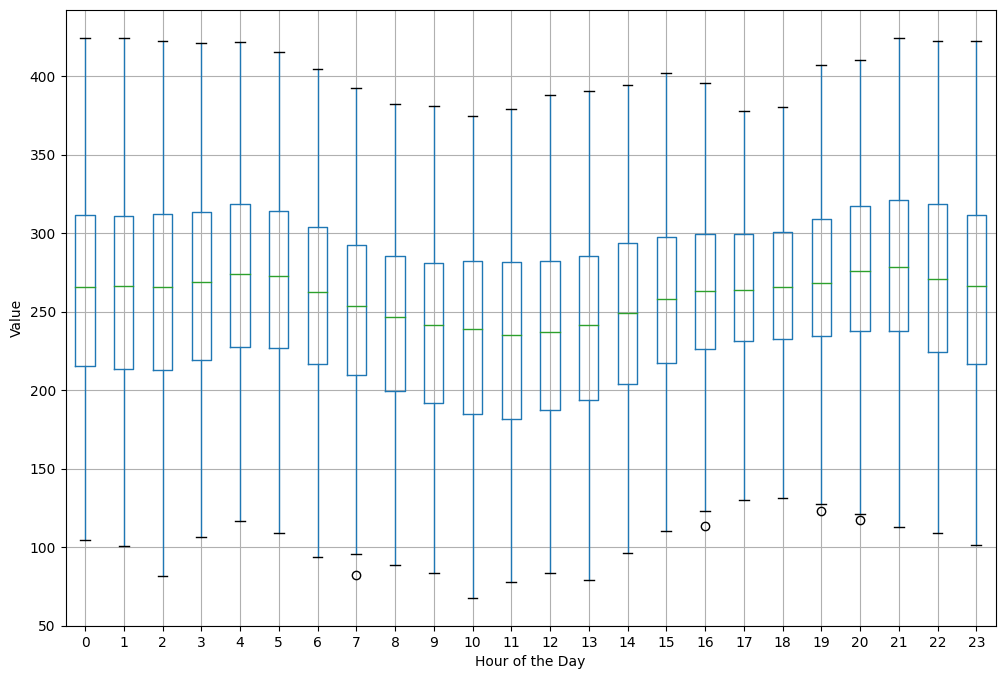

In [ ]:
uni_df=df['Carbon Intensity gCO₂eq/kWh (direct)']

hourly_data = uni_df.values.reshape(-1, 24)

hourly_df = pd.DataFrame(hourly_data, columns=np.arange(24))

hourly_df.boxplot(figsize=(12, 8))

plt.xlabel('Hour of the Day')
plt.ylabel('Value')

plt.show()


In [ ]:
data_matrix = np.array(uni_df).reshape(-1, 1)

lable_size=6
window_size = 24 + lable_size
step_size = 1

combined_data = []

for i in range(0, len(data_matrix) - window_size + 1, step_size):

    window = data_matrix[i:i+window_size]

    combined_data.append(window.flatten())

tw_df = np.array(combined_data)

print("Shape of combined_data_matrix:", tw_df.shape)  # (26251, 30)

l=[]
for i in range(23, tw_df.shape[0]+23):
  l.append(df['Datetime (UTC)'][i])
tw_df=pd.DataFrame(tw_df)
tw_df['index']=l
tw_df.set_index('index', inplace=True)
tw_df.reset_index(inplace=True)
column_mapping = {'index ': '0'}
for i in range(30):
    column_mapping[i] = str(i + 1)
tw_df.rename(columns=column_mapping, inplace=True)
tw_df.rename(columns={'index': '0'}, inplace=True)
tw_df.head()

Shape of combined_data_matrix: (26251, 30)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,2021010123,303.29,303.45,295.04,295.56,308.06,302.32,279.98,267.33,272.62,...,267.10,285.47,292.68,315.01,309.16,310.88,312.47,307.71,313.31,299.05
1,2021010200,303.45,295.04,295.56,308.06,302.32,279.98,267.33,272.62,280.13,...,285.47,292.68,315.01,309.16,310.88,312.47,307.71,313.31,299.05,273.42
2,2021010201,295.04,295.56,308.06,302.32,279.98,267.33,272.62,280.13,294.88,...,292.68,315.01,309.16,310.88,312.47,307.71,313.31,299.05,273.42,264.03
3,2021010202,295.56,308.06,302.32,279.98,267.33,272.62,280.13,294.88,287.16,...,315.01,309.16,310.88,312.47,307.71,313.31,299.05,273.42,264.03,257.06
4,2021010203,308.06,302.32,279.98,267.33,272.62,280.13,294.88,287.16,285.02,...,309.16,310.88,312.47,307.71,313.31,299.05,273.42,264.03,257.06,250.32


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

features = tw_df.iloc[:, :25].values
labels = tw_df.iloc[:, 25:].values

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(features)
# labels_scaled = scaler.fit_transform(labels)


# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# features = scaler.fit_transform(features)
# labels_scaled = scaler.fit_transform(labels)

from sklearn.preprocessing import RobustScaler
scaler_feature = RobustScaler()
scaler_label = RobustScaler()

real=features
features = scaler_feature.fit_transform(features)
labels_scaled = scaler_label.fit_transform(labels)

# from sklearn.preprocessing import Normalizer
# scaler = Normalizer()
# features = scaler.fit_transform(features)
# labels_scaled = scaler.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(features, labels_scaled, test_size=0.2)

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_data = pd.concat([X_train_df, y_train_df], axis=1)
numpy_array = train_data.values

concatenated_array = np.concatenate((X_test, y_test), axis=1)
batch_size=126
import torch
from torch.utils.data import Dataset
random_state=42

class MyDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
    if random_state is not None:
        torch.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)

    def __len__(self):
        return len(self.data) - self.sequence_length+ 1


    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_length]
        input_sequence = sequence[0][:25].reshape(1,25)
        output_sequence = sequence[0][25:].reshape(1,6)
        return input_sequence, output_sequence

sequence_length = 1

train_dataset = MyDataset(numpy_array,sequence_length)
test_dataset = MyDataset(concatenated_array,sequence_length)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


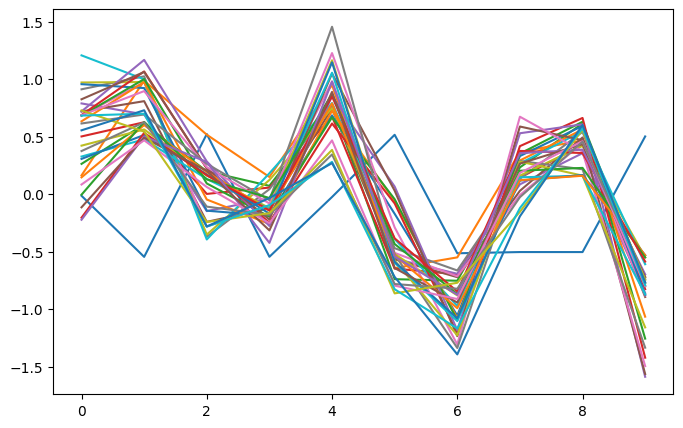

In [ ]:
n=980
plt.figure(figsize=(8, 5))
plt.plot(concatenated_array[n:10+n])
plt.show()

In [ ]:
input_size = X_train.shape[1]
learning_rate= 0.001
hidden_units= 64
dropout=0.0
num_epochs = 20
batch_size=128
num_layers=1
output_size=lable_size
import torch.nn.functional as F

class ModelTwo(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False, dropout=0.2):
        super(ModelTwo, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.embedding = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size,self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        x = self.embedding(x)
        # x = F.relu(x)
        x, _ = self.lstm(x, (h0, c0))
        x = self.fc1(x)
        # x = x.permute(0, 2, 1)
        # x = self.batch_norm1(x)
        # x = x.permute(0, 2, 1)
        # x = F.relu(x)
        x = self.fc2(x)
        return x


model_Two = ModelTwo(input_size, hidden_units,num_layers, output_size)

optimizer = torch.optim.Adam(model_Two.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.SmoothL1Loss()



In [ ]:
model_Two.train()
print('Training Model Two')
for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(torch.float32)
        batch_y = batch_y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model_Two(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Training Model Two
Epoch [1/20], Loss: 0.0516
Epoch [2/20], Loss: 0.0255
Epoch [3/20], Loss: 0.0244
Epoch [4/20], Loss: 0.0241
Epoch [5/20], Loss: 0.0237
Epoch [6/20], Loss: 0.0234
Epoch [7/20], Loss: 0.0234
Epoch [8/20], Loss: 0.0231
Epoch [9/20], Loss: 0.0229
Epoch [10/20], Loss: 0.0228
Epoch [11/20], Loss: 0.0229
Epoch [12/20], Loss: 0.0227
Epoch [13/20], Loss: 0.0226
Epoch [14/20], Loss: 0.0226
Epoch [15/20], Loss: 0.0223
Epoch [16/20], Loss: 0.0223
Epoch [17/20], Loss: 0.0223
Epoch [18/20], Loss: 0.0221
Epoch [19/20], Loss: 0.0220
Epoch [20/20], Loss: 0.0220


In [ ]:
model_Two.eval()
predictions_list = []
with torch.no_grad():
    total_mse = 0
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(torch.float32)
        batch_y = batch_y.to(torch.float32)
        predictions = model_Two(batch_X).numpy()
        predictions_list.append(predictions)
        total_mse += np.mean((predictions - batch_y.numpy()) ** 2)
mse2 = total_mse / len(test_loader)
print(f'Mean Squared Error (MSE) of model_Two: {mse2:.4f}')

Mean Squared Error (MSE) of model_Two: 0.0471


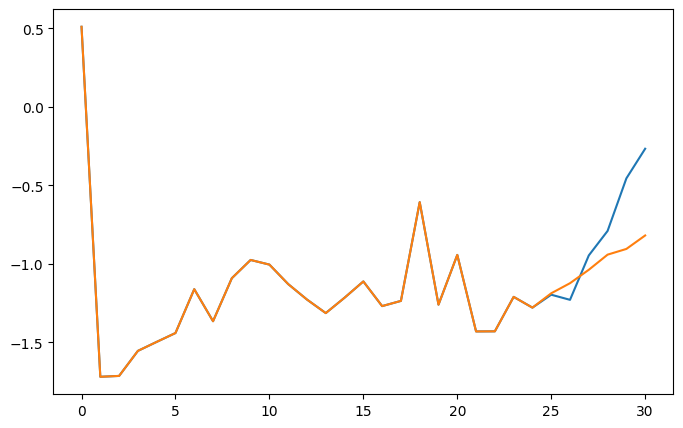

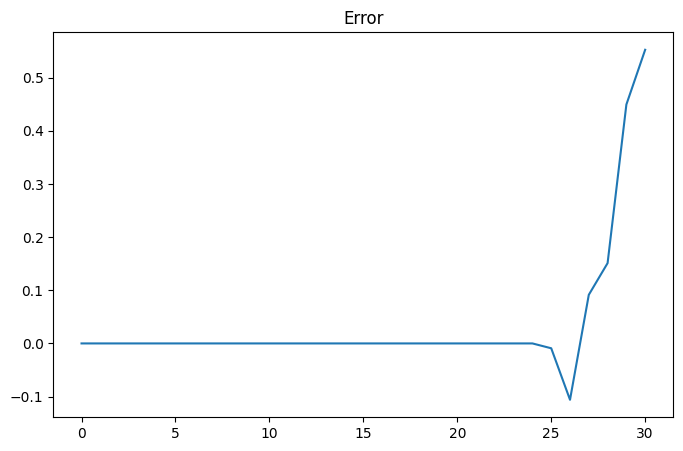

In [ ]:
n=5222
flat_predictions = [prediction for batch_predictions in predictions_list for prediction in batch_predictions]
flat_predictions = np.array(flat_predictions)
flat_predictions=flat_predictions.reshape(5251,6)
x=np.concatenate((concatenated_array[n,0:25],flat_predictions[n]), axis=0)


plt.figure(figsize=(8, 5))
plt.plot(concatenated_array[n])
plt.plot(x)
plt.show()



plt.figure(figsize=(8,5))
plt.title('Error')
plt.plot(concatenated_array[n]-x)
plt.show()

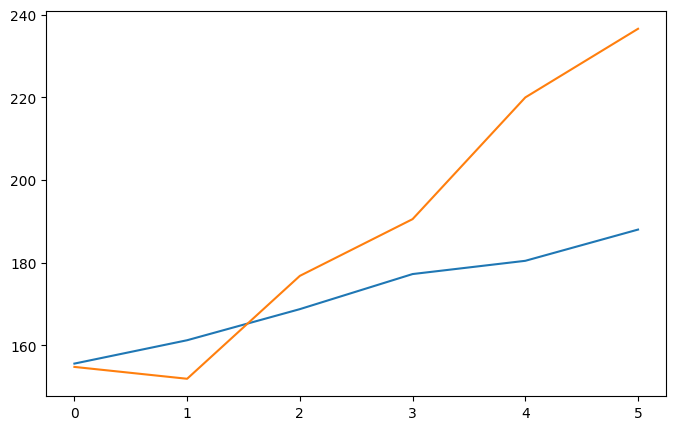

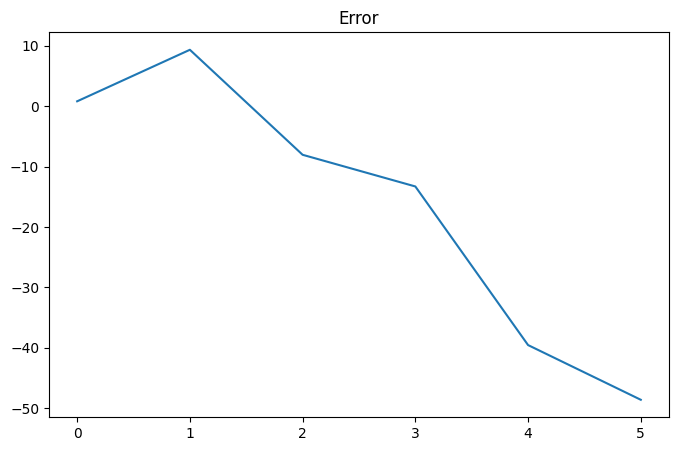

In [ ]:

flat_predictions = [prediction for batch_predictions in predictions_list for prediction in batch_predictions]
flat_predictions = np.array(flat_predictions)
flat_predictions=flat_predictions.reshape(5251,6)
predictions_original6 = scaler_label.inverse_transform(flat_predictions)
array2_original = scaler_label.inverse_transform(y_test)


plt.figure(figsize=(8,5))
plt.plot(predictions_original6[n])
plt.plot(array2_original[n])
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Error')
plt.plot(predictions_original6[n]-array2_original[n])
plt.show()

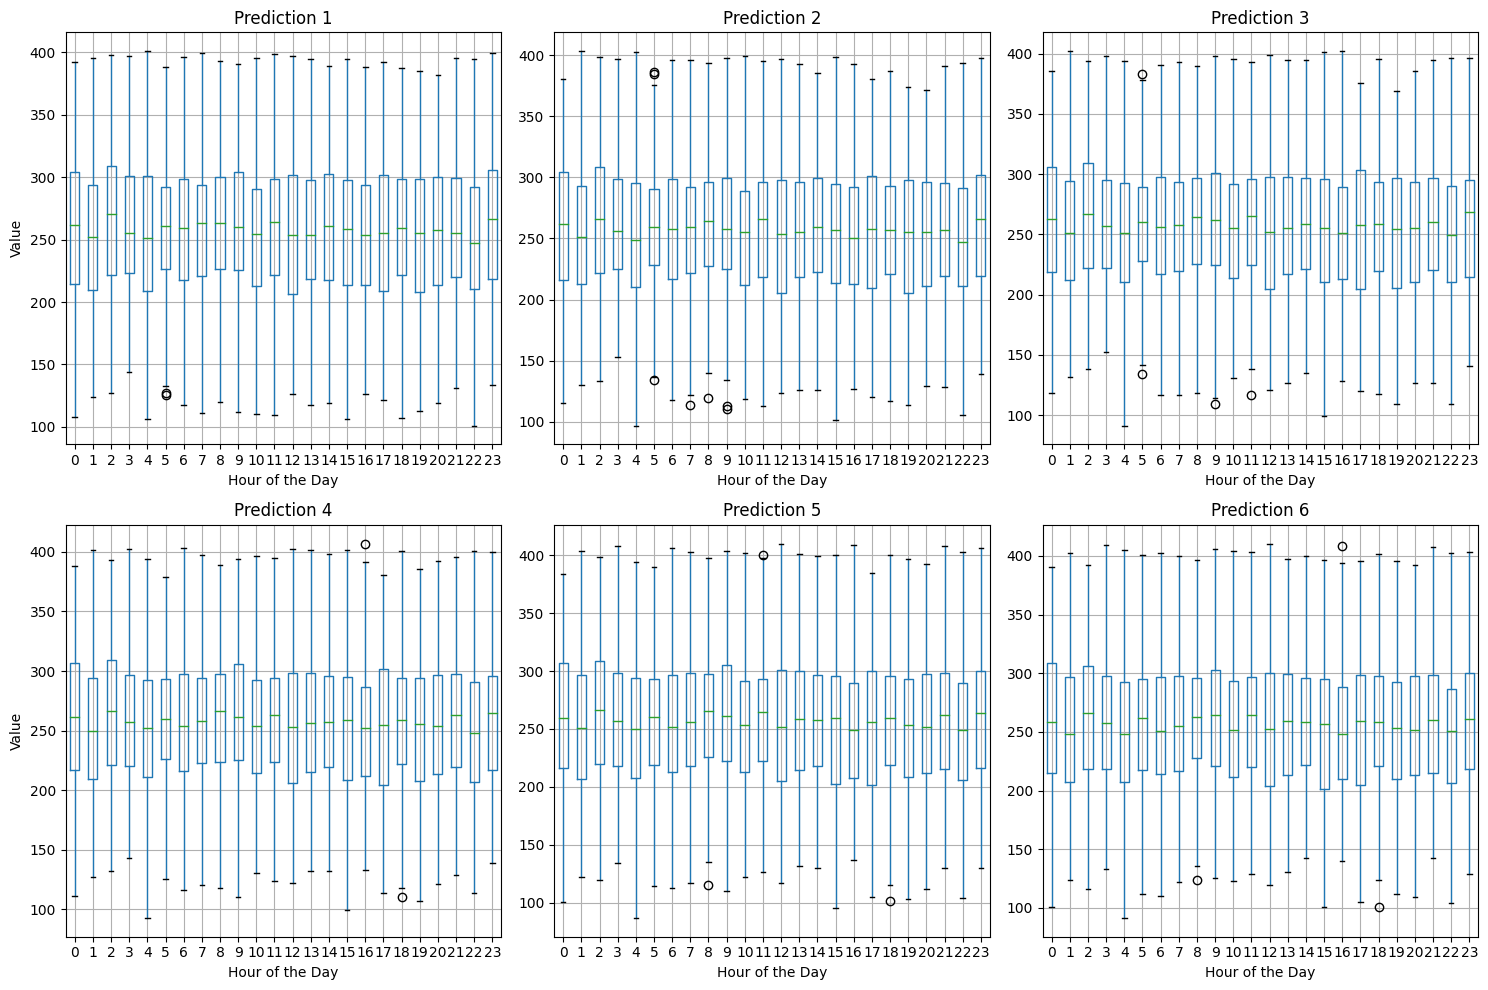

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 plots
for i, ax in enumerate(axes.flat):
    prediction = predictions_original6[:5232, i]
    error = predictions_original6[:5232, i] - array2_original[:5232, i]

    prediction = pd.Series(prediction)
    error = pd.Series(error)

    prediction = prediction.values.reshape(-1, 24)
    error = error.values.reshape(-1, 24)

    prediction = pd.DataFrame(prediction, columns=np.arange(24))
    prediction.boxplot(ax=ax)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Value')
    ax.set_title(f'Prediction {i+1}')

    if i % 3 != 0:  # Hide y-axis label for plots in the second row
        ax.set_ylabel('')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


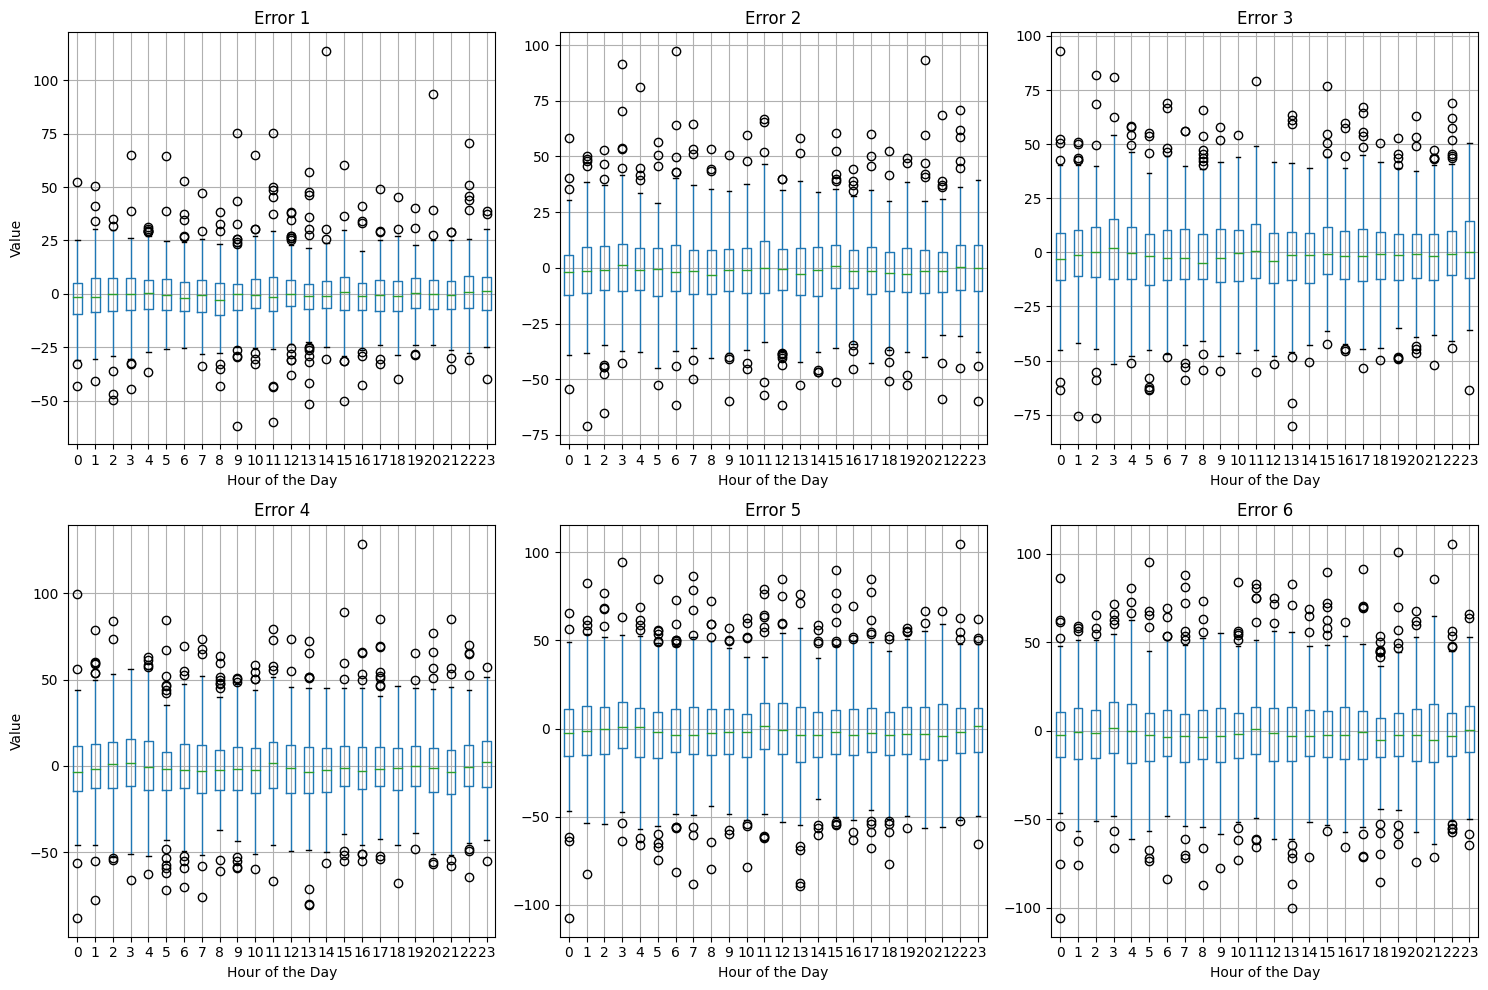

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 plots
for i, ax in enumerate(axes.flat):
    error = predictions_original6[:5232, i] - array2_original[:5232, i]

    error = pd.Series(error)

    error = error.values.reshape(-1, 24)

    error = pd.DataFrame(error, columns=np.arange(24))
    error.boxplot(ax=ax)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Value')
    ax.set_title(f'Error {i+1}')

    if i % 3 != 0:  # Hide y-axis label for plots in the second row
        ax.set_ylabel('')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [ ]:
data_matrix = np.array(uni_df).reshape(-1, 1)

lable_size=720
window_size = 720 + lable_size
step_size = 1

combined_data = []

for i in range(0, len(data_matrix) - window_size + 1, step_size):

    window = data_matrix[i:i+window_size]

    combined_data.append(window.flatten())

tw_df = np.array(combined_data)

print("Shape of combined_data_matrix:", tw_df.shape)

l=[]
for i in range(23, tw_df.shape[0]+23):
  l.append(df['Datetime (UTC)'][i])
tw_df=pd.DataFrame(tw_df)
tw_df['index']=l
tw_df.set_index('index', inplace=True)
tw_df.reset_index(inplace=True)
column_mapping = {'index ': '0'}
for i in range(30):
    column_mapping[i] = str(i + 1)
tw_df.rename(columns=column_mapping, inplace=True)
tw_df.rename(columns={'index': '0'}, inplace=True)
tw_df.head(20)

Shape of combined_data_matrix: (24841, 1440)


,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,2021010123,303.29,303.45,295.04,295.56,308.06,302.32,279.98,267.33,272.62,...,253.49,262.33,267.67,274.37,272.69,268.65,287.64,283.46,287.27,282.46
1,2021010200,303.45,295.04,295.56,308.06,302.32,279.98,267.33,272.62,280.13,...,262.33,267.67,274.37,272.69,268.65,287.64,283.46,287.27,282.46,279.05
2,2021010201,295.04,295.56,308.06,302.32,279.98,267.33,272.62,280.13,294.88,...,267.67,274.37,272.69,268.65,287.64,283.46,287.27,282.46,279.05,286.65
3,2021010202,295.56,308.06,302.32,279.98,267.33,272.62,280.13,294.88,287.16,...,274.37,272.69,268.65,287.64,283.46,287.27,282.46,279.05,286.65,300.36
4,2021010203,308.06,302.32,279.98,267.33,272.62,280.13,294.88,287.16,285.02,...,272.69,268.65,287.64,283.46,287.27,282.46,279.05,286.65,300.36,308.24
5,2021010204,302.32,279.98,267.33,272.62,280.13,294.88,287.16,285.02,283.08,...,268.65,287.64,283.46,287.27,282.46,279.05,286.65,300.36,308.24,306.72
6,2021010205,279.98,267.33,272.62,280.13,294.88,287.16,285.02,283.08,289.65,...,287.64,283.46,287.27,282.46,279.05,286.65,300.36,308.24,306.72,277.50
7,2021010206,267.33,272.62,280.13,294.88,287.16,285.02,283.08,289.65,274.74,...,283.46,287.27,282.46,279.05,286.65,300.36,308.24,306.72,277.50,269.11
8,2021010207,272.62,280.13,294.88,287.16,285.02,283.08,289.65,274.74,246.37,...,287.27,282.46,279.05,286.65,300.36,308.24,306.72,277.50,269.11,252.21
9,2021010208,280.13,294.88,287.16,285.02,283.08,289.65,274.74,246.37,233.64,...,282.46,279.05,286.65,300.36,308.24,306.72,277.50,269.11,252.21,255.89


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

features = tw_df.iloc[:, :721].values
labels = tw_df.iloc[:, 721:].values


from sklearn.preprocessing import RobustScaler
scaler_feature = RobustScaler()
scaler_label = RobustScaler()

real=features
features = scaler_feature.fit_transform(features)
labels_scaled = scaler_label.fit_transform(labels)


train_start_date = 0
train_end_date = 16560
test_start_date = 16561

X_train = features[train_start_date:train_end_date]
X_test = features[test_start_date:]
y_train= labels_scaled[train_start_date:train_end_date]
y_test = labels_scaled[test_start_date:]
# X_train, X_test, y_train, y_test = train_test_split(features, labels_scaled, test_size=0.2)

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_data = pd.concat([X_train_df, y_train_df], axis=1)
numpy_array = train_data.values

concatenated_array = np.concatenate((X_test, y_test), axis=1)
batch_size=126
import torch
from torch.utils.data import Dataset
random_state=42

class MyDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
    if random_state is not None:
        torch.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)

    def __len__(self):
        return len(self.data) - self.sequence_length+ 1


    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.sequence_length]
        input_sequence = sequence[0][:721].reshape(1,721)
        output_sequence = sequence[0][721:].reshape(1,720)
        return input_sequence, output_sequence

sequence_length = 1

train_dataset = MyDataset(numpy_array,sequence_length)
test_dataset = MyDataset(concatenated_array,sequence_length)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
input_size = X_train.shape[1]
learning_rate= 0.001
hidden_units= 1024
dropout=0.0
num_epochs = 20
batch_size=128
num_layers=1
output_size=lable_size
import torch.nn.functional as F

class ModelTwo(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout=0.2):
        super(ModelTwo, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.embedding = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc1 = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size,self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), batch_size, self.hidden_size).to(x.device)
        x = self.embedding(x)
        # x = F.relu(x)
        x, _ = self.lstm(x, (h0, c0))
        x = self.fc1(x)
        # x = x.permute(0, 2, 1)
        # x = self.batch_norm1(x)
        # x = x.permute(0, 2, 1)
        # x = F.relu(x)
        x = self.fc2(x)
        return x


model_Two = ModelTwo(input_size, hidden_units,num_layers, output_size)

optimizer = torch.optim.Adam(model_Two.parameters(), lr=learning_rate)
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = nn.SmoothL1Loss()



In [ ]:
model_Two.train()
print('Training Model Two')
for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(torch.float32)
        batch_y = batch_y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model_Two(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Training Model Two
Epoch [1/20], Loss: 0.0959
Epoch [2/20], Loss: 0.0387
Epoch [3/20], Loss: 0.0206
Epoch [4/20], Loss: 0.0156
Epoch [5/20], Loss: 0.0137
Epoch [6/20], Loss: 0.0123
Epoch [7/20], Loss: 0.0112
Epoch [8/20], Loss: 0.0104
Epoch [9/20], Loss: 0.0104
Epoch [10/20], Loss: 0.0095
Epoch [11/20], Loss: 0.0086
Epoch [12/20], Loss: 0.0087
Epoch [13/20], Loss: 0.0106
Epoch [14/20], Loss: 0.0087
Epoch [15/20], Loss: 0.0074
Epoch [16/20], Loss: 0.0069
Epoch [17/20], Loss: 0.0068
Epoch [18/20], Loss: 0.0076
Epoch [19/20], Loss: 0.0070
Epoch [20/20], Loss: 0.0066


In [ ]:
model_Two.eval()
predictions_list = []
with torch.no_grad():
    total_mse = 0
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(torch.float32)
        batch_y = batch_y.to(torch.float32)
        predictions = model_Two(batch_X).numpy()
        predictions_list.append(predictions)
        total_mse += np.mean((predictions - batch_y.numpy()) ** 2)
mse2 = total_mse / len(test_loader)
print(f'Mean Squared Error (MSE) of model_Two: {mse2:.4f}')

Mean Squared Error (MSE) of model_Two: 0.2641


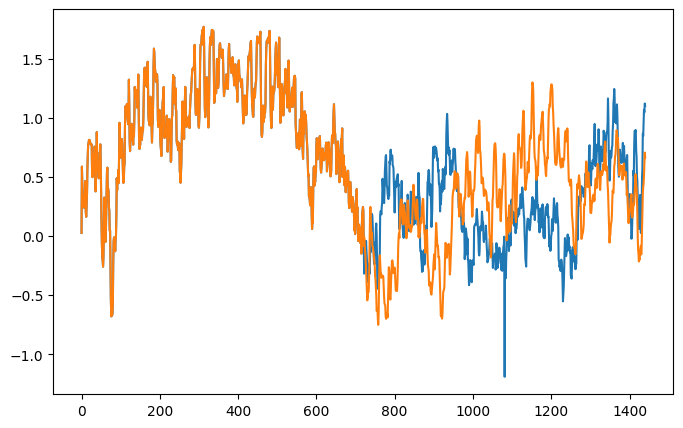

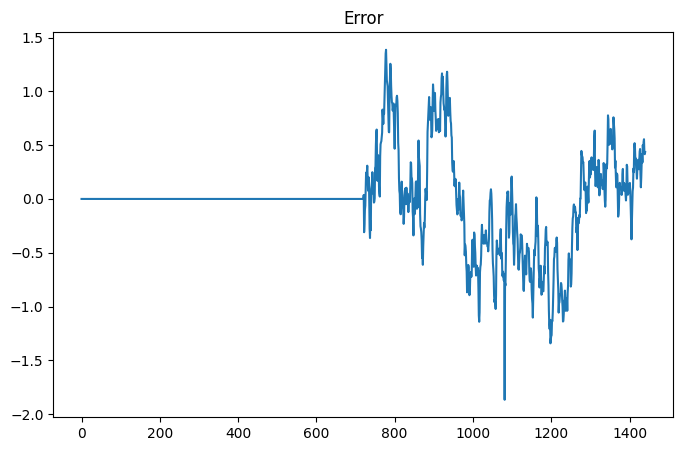

In [ ]:
n=52
flat_predictions = [prediction for batch_predictions in predictions_list for prediction in batch_predictions]
flat_predictions = np.array(flat_predictions)
flat_predictions=flat_predictions.reshape(8280,720)
x=np.concatenate((concatenated_array[n,0:721],flat_predictions[n]), axis=0)


plt.figure(figsize=(8, 5))
plt.plot(concatenated_array[n])
plt.plot(x)
plt.show()



plt.figure(figsize=(8,5))
plt.title('Error')
plt.plot(concatenated_array[n]-x)
plt.show()

In [ ]:
24*30

720

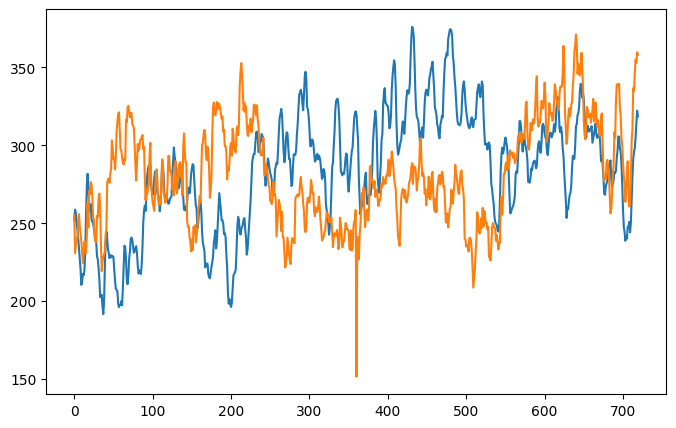

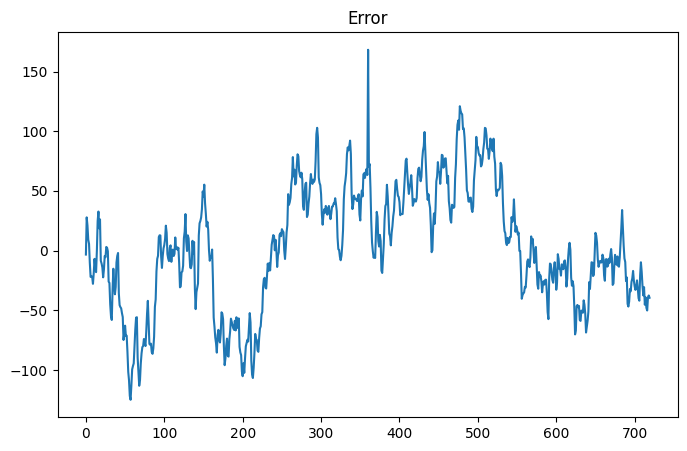

In [ ]:

flat_predictions = [prediction for batch_predictions in predictions_list for prediction in batch_predictions]
flat_predictions = np.array(flat_predictions)
flat_predictions=flat_predictions.reshape(8280,720)
predictions_original6 = scaler_label.inverse_transform(flat_predictions)
array2_original = scaler_label.inverse_transform(y_test)


plt.figure(figsize=(8,5))
plt.plot(predictions_original6[n])
plt.plot(array2_original[n])
plt.show()

plt.figure(figsize=(8, 5))
plt.title('Error')
plt.plot(predictions_original6[n]-array2_original[n])
plt.show()

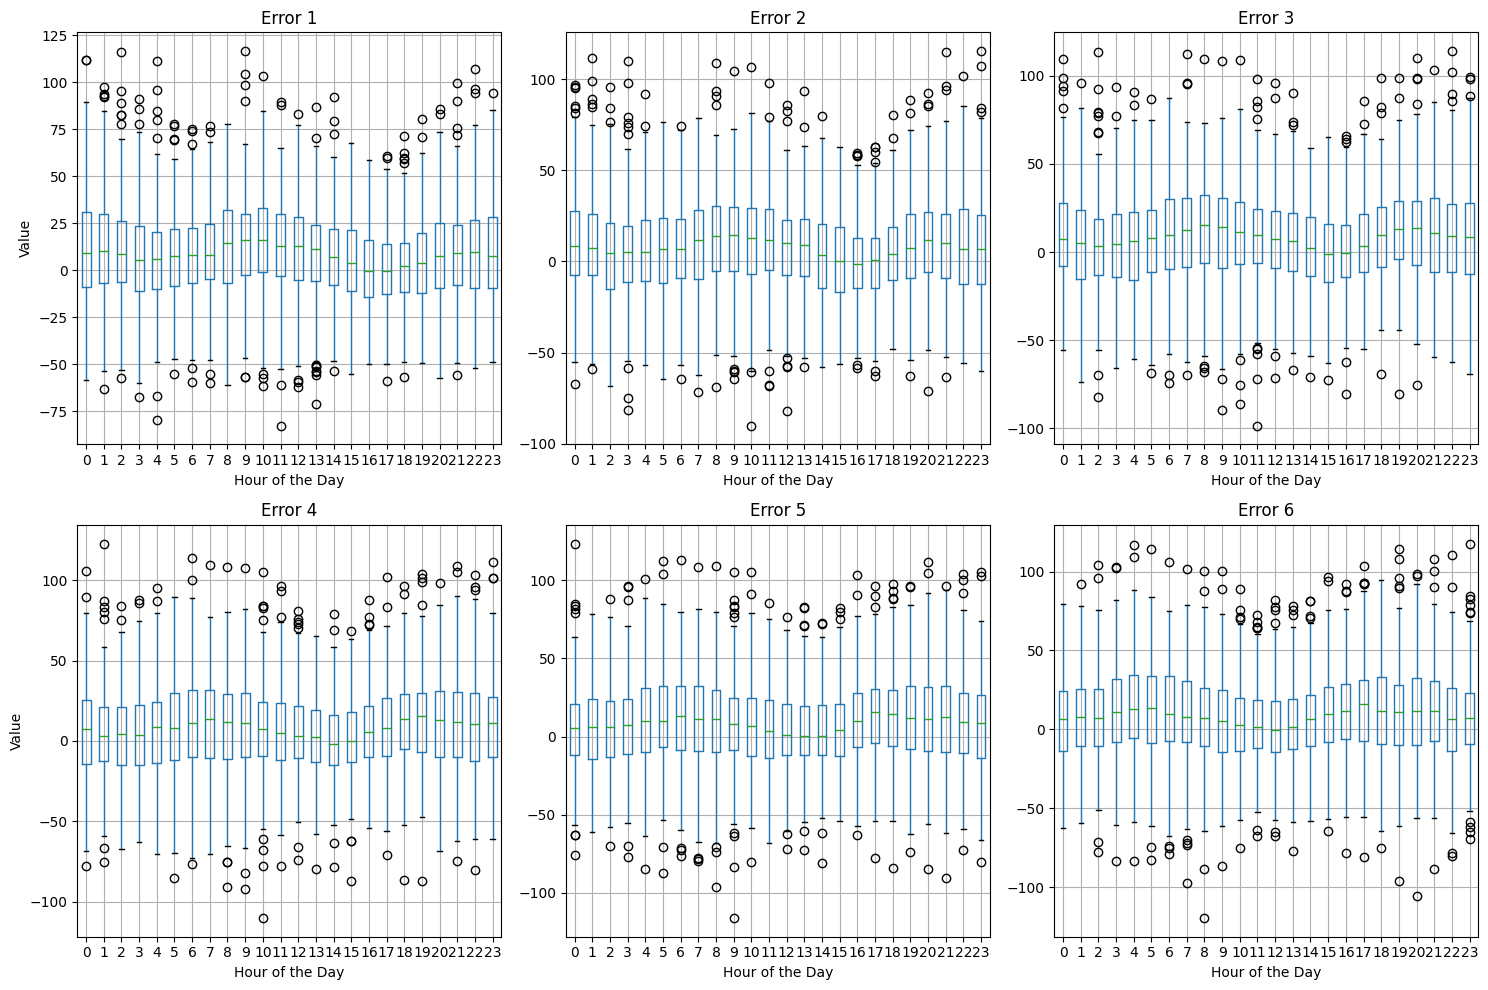

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 plots
for i, ax in enumerate(axes.flat):
    error = predictions_original6[:5232, i] - array2_original[:5232, i]

    error = pd.Series(error)

    error = error.values.reshape(-1, 24)

    error = pd.DataFrame(error, columns=np.arange(24))
    error.boxplot(ax=ax)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Value')
    ax.set_title(f'Error {i+1}')

    if i % 3 != 0:  # Hide y-axis label for plots in the second row
        ax.set_ylabel('')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
